In [153]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.compare import compare_survival
from sksurv.datasets import get_x_y

In [111]:
df_tcga_clinical = pd.read_csv("/home/cke/TCGA_HNSCC_clinical_data.tsv",sep='\t')

In [112]:
df_tcga_clinical

,Study ID,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Alcohol Consumption Frequency,...,Specimen Second Longest Dimension,Stage Other,Time between clamping and freezing,Time between excision and freezing,Tissue Source Site,Patient Smoking History Category,Primary Therapy Outcome Success Type,Person Neoplasm Status,Vial number,Patient's Vital Status
0,hnsc_tcga,TCGA-4P-AA8J,TCGA-4P-AA8J-01,66.0,MX,N2c,Stage IVA,7th,T2,NaN,...,NaN,NaN,NaN,NaN,4P,[Unknown],Complete Remission/Response,TUMOR FREE,A,Alive
1,hnsc_tcga,TCGA-BA-4074,TCGA-BA-4074-01,69.0,M0,N2c,Stage IVA,6th,T2,NaN,...,0.7,NaN,NaN,NaN,BA,2,NaN,WITH TUMOR,A,Dead
2,hnsc_tcga,TCGA-BA-4075,TCGA-BA-4075-01,49.0,M0,N0,Stage III,6th,T3,7.0,...,0.7,NaN,NaN,NaN,BA,2,NaN,WITH TUMOR,A,Dead
3,hnsc_tcga,TCGA-BA-4076,TCGA-BA-4076-01,39.0,NaN,NX,NaN,6th,TX,NaN,...,0.6,NaN,NaN,NaN,BA,2,NaN,WITH TUMOR,A,Dead
4,hnsc_tcga,TCGA-BA-4077,TCGA-BA-4077-01,45.0,M0,N0,Stage IVA,6th,T4a,0.0,...,0.5,NaN,NaN,NaN,BA,4,NaN,WITH TUMOR,B,Dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,hnsc_tcga,TCGA-UF-A7JT,TCGA-UF-A7JT-01,72.0,M0,N0,Stage IVA,6th,T4a,NaN,...,NaN,NaN,NaN,NaN,UF,1,Complete Remission/Response,WITH TUMOR,A,Dead
526,hnsc_tcga,TCGA-UF-A7JV,TCGA-UF-A7JV-01,62.0,M0,N2b,Stage IVA,7th,T4a,NaN,...,NaN,NaN,NaN,NaN,UF,1,Complete Remission/Response,WITH TUMOR,A,Dead
527,hnsc_tcga,TCGA-UP-A6WW,TCGA-UP-A6WW-01,58.0,NaN,NaN,NaN,7th,NaN,7.0,...,NaN,NaN,NaN,NaN,UP,1,Complete Remission/Response,TUMOR FREE,A,Alive
528,hnsc_tcga,TCGA-WA-A7GZ,TCGA-WA-A7GZ-01,58.0,NaN,N0,NaN,7th,T2,NaN,...,NaN,NaN,NaN,NaN,WA,2,Complete Remission/Response,TUMOR FREE,A,Dead


In [113]:
df_tcga_survival = df_tcga_clinical.loc[:,['Patient ID','Overall Survival (Months)','Overall Survival Status']]
# df_tcga_survival

In [114]:
df_tcga_survival.dropna(inplace=True)
df_tcga_survival

,Patient ID,Overall Survival (Months),Overall Survival Status
0,TCGA-4P-AA8J,3.35,LIVING
1,TCGA-BA-4074,15.18,DECEASED
2,TCGA-BA-4075,9.30,DECEASED
3,TCGA-BA-4076,13.63,DECEASED
4,TCGA-BA-4077,37.25,DECEASED
...,...,...,...
525,TCGA-UF-A7JT,32.62,DECEASED
526,TCGA-UF-A7JV,2.96,DECEASED
527,TCGA-UP-A6WW,17.02,LIVING
528,TCGA-WA-A7GZ,20.53,DECEASED


## Prepare df_merged as in pipeline_downstream_analysis-show


In [115]:
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top100DEGs.csv",index_col=0)
res_prevail['sample'] = res_prevail.index.tolist()
res_prevail['sample'] = res_prevail['sample'].str.rstrip('A')
# res_prevail
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail_subtypes = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_ImmuneSubtypes_real_top100DEGs_Aug8.csv",index_col=0)
res_prevail_subtypes['sample'] = res_prevail_subtypes.index.tolist()
res_prevail_subtypes['sample'] = res_prevail_subtypes['sample'].str.rstrip('A')
# res_prevail_subtypes
# read in fga data table from Kari's plots
fga_Kari = pd.read_csv("/home/cke/KariPDF/fga_table.csv",header=None)
fga_Kari.columns = ['sample','fga']
# using cellularity extracted from Kari's plots pdf 
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
# cellularity_Kari
# fga_Kari
df_merged = pd.merge(res_prevail,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
df_merged_subtypes = pd.merge(res_prevail_subtypes,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
# Merging fga + cell type fractions 

In [116]:
def define_FGA(fga):
    if fga > 0.2:
        return 'High'
    else:
        return 'Silent'
df_merged['FGA_status'] = df_merged['fga'].apply(define_FGA)
df_merged_subtypes['FGA_status'] = df_merged_subtypes['fga'].apply(define_FGA)

Nulton = pd.read_excel("/home/cke/Nulton 2017 - supplementary.xlsx",sheet_name=1)
# Nulton
TCGA_pheno = pd.read_csv("/home/cke/TCGA-HNSC.GDC_phenotype.tsv",sep='\t')
TCGA_pheno['hpv_status']=''
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Positive'),'hpv_status']='Positive'
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Negative') & (TCGA_pheno['hpv_status_by_p16_testing']=='Negative'),'hpv_status']='Negative'
# TCGA_pheno['hpv_status'].value_counts()
TCGA_pheno['sample'] = TCGA_pheno['submitter_id.samples'].str.rsplit("-",n=1,expand=True)[0]
list_pos_tcgaPheno = TCGA_pheno[TCGA_pheno['hpv_status']=='Positive']['sample'].tolist()
list_pos_Nulton = Nulton['HNSCC Barcode'].tolist()
# remove conflict samples between TCGA annotation and Nulton et al.
list_remove = []
for i in list_pos_tcgaPheno:
    if i not in list_pos_Nulton:
        list_remove.append(i)
# list_remove

/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [117]:
set_pos = list_pos_Nulton
print("We gathered",len(list_pos_Nulton),"Positive samples from two source") 
print("We removed",len(list_remove),"conflicting samples") 

We gathered 72 Positive samples from two source
We removed 10 conflicting samples


In [118]:
dict_primary_site = {'Alveolar Ridge': 'Oral Cavity',
 'Floor of mouth': 'Oral Cavity',
 'Palate': 'Oral Cavity',
 'Lip': 'Oral Cavity',
 'Oral Tongue': 'Oral Cavity',
 'Oral Cavity': 'Oral Cavity',
 'Other and unspecified parts of tongue': 'Oral Cavity',
 'Other and unspecified parts of mouth': 'Oral Cavity',
 'Base of tongue': 'Oropharynx',
 'Tonsil': 'Oropharynx',
 'Oropharynx': 'Oropharynx',
    'Larynx': 'Larynx',    
    'Floor of mouth':'Oral Cavity',
    'Gum':'Oral Cavity',
    'Oropharynx':'Oropharynx',
    'Hypopharynx':'Hypopharynx',}
TCGA_pheno_new = TCGA_pheno.copy()
TCGA_pheno_new['primary_site'] = TCGA_pheno_new['primary_site'].map(dict_primary_site)
TCGA_pheno_new.dropna(subset='primary_site',inplace=True)

#Selecting only primary tumor!
TCGA_pheno_new = TCGA_pheno_new[TCGA_pheno_new['sample_type.samples']=='Primary Tumor']
TCGA_pheno_new['primary_site'].value_counts()

df_merged['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_sites = pd.merge(df_merged,TCGA_pheno_new[['sample','primary_site']],left_on='sample_match',right_on='sample')
# df_merged_sites

df_merged_subtypes['sample_match'] = df_merged_subtypes['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_subtypes_sites = pd.merge(df_merged_subtypes,TCGA_pheno_new[['sample','primary_site']],left_on='sample_match',right_on='sample')
# df_merged_subtypes_sites

In [119]:
df_merged_sites = pd.merge(df_merged_sites,df_tcga_survival,left_on='sample_match',right_on='Patient ID',how='left')
df_merged_subtypes_sites = pd.merge(df_merged_subtypes_sites,df_tcga_survival,left_on='sample_match',right_on='Patient ID',how='left')

In [120]:
df_merged_HPVpos = df_merged_sites.copy()
df_merged_HPVpos = df_merged_HPVpos[df_merged_HPVpos['sample_match'].isin(set_pos)]
df_merged_HPVpos['hpv_status'] = "Positive"
# df_merged_HPVpos
print(df_merged_HPVpos.shape[0])
df_merged_HPVneg = df_merged_sites.copy()
df_merged_HPVneg = df_merged_HPVneg[~df_merged_HPVneg['sample_match'].isin(set_pos) & ~df_merged_HPVneg['sample_match'].isin(list_remove)]
df_merged_HPVneg['hpv_status'] = "Negative"
# df_merged_HPVneg
print(df_merged_HPVneg.shape[0])
df_merged_HPVpos_subtypes = df_merged_subtypes_sites.copy()
df_merged_HPVpos_subtypes = df_merged_HPVpos_subtypes[df_merged_HPVpos_subtypes['sample_match'].isin(set_pos)]
df_merged_HPVpos_subtypes['hpv_status'] = "Positive"
# df_merged_HPVpos
print(df_merged_HPVpos_subtypes.shape[0])
df_merged_HPVneg_subtypes = df_merged_subtypes_sites.copy()
df_merged_HPVneg_subtypes = df_merged_HPVneg_subtypes[~df_merged_HPVneg_subtypes['sample_match'].isin(set_pos) & ~df_merged_HPVneg_subtypes['sample_match'].isin(list_remove)]
df_merged_HPVneg_subtypes['hpv_status'] = "Negative"
# df_merged_HPVneg
print(df_merged_HPVneg_subtypes.shape[0])
# Ultimate dataframe containing all information
df_merged_nonrelative = pd.concat([df_merged_HPVpos,df_merged_HPVneg])
df_merged_subtypes_nonrelative = pd.concat([df_merged_HPVpos_subtypes,df_merged_HPVneg_subtypes])

60
354
60
354


In [121]:
df_merged_nonrelative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,...,cellularity,fga,FGA_status,sample_match,sample_y,primary_site,Patient ID,Overall Survival (Months),Overall Survival Status,hpv_status
2,5.709435e-03,0.003259,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,...,0.36,0.572,High,TCGA-CN-5374,TCGA-CN-5374,Oropharynx,TCGA-CN-5374,56.90,DECEASED,Positive
6,8.058788e-03,0.004823,0.053060,0.050577,0.088309,0.001369,9.219069e-07,1.354588e-06,0.031462,0.762338,...,0.48,0.098,Silent,TCGA-CR-5249,TCGA-CR-5249,Oropharynx,TCGA-CR-5249,37.84,LIVING,Positive
24,3.396785e-03,0.041641,0.040713,0.013894,0.158393,0.000163,6.779418e-04,1.593186e-06,0.041585,0.699535,...,0.66,0.245,High,TCGA-CV-6433,TCGA-CV-6433,Oral Cavity,TCGA-CV-6433,21.06,LIVING,Positive
33,9.403402e-03,0.003327,0.024324,0.302406,0.185639,0.000672,9.655291e-07,1.128296e-06,0.020712,0.453513,...,0.27,0.436,High,TCGA-H7-A76A,TCGA-H7-A76A,Oropharynx,TCGA-H7-A76A,20.93,LIVING,Positive
41,1.096958e-02,0.048059,0.060456,0.054257,0.097379,0.000084,5.340647e-03,1.951452e-06,0.038107,0.685345,...,0.56,0.542,High,TCGA-BB-4225,TCGA-BB-4225,Oropharynx,TCGA-BB-4225,4.80,LIVING,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,4.269644e-05,0.000016,0.018005,0.019971,0.009111,0.000082,7.632417e-03,3.212852e-04,0.002373,0.942446,...,0.63,0.562,High,TCGA-C9-A47Z,TCGA-C9-A47Z,Oral Cavity,TCGA-C9-A47Z,6.27,DECEASED,Negative
413,6.054611e-03,0.000002,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,...,0.36,0.736,High,TCGA-CN-6010,TCGA-CN-6010,Larynx,TCGA-CN-6010,50.03,LIVING,Negative
414,2.447322e-07,0.000006,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,...,0.40,0.778,High,TCGA-CV-7235,TCGA-CV-7235,Oral Cavity,TCGA-CV-7235,77.10,LIVING,Negative
415,1.076841e-03,0.000132,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,...,0.61,0.642,High,TCGA-CX-7086,TCGA-CX-7086,Oral Cavity,TCGA-CX-7086,18.82,LIVING,Negative


### 3 by 2-setups: Decon results from major cell types and immune subtypes
-	HPV- negative oral cavity CNA-silent vs nonsilent
-	HPV-negative oropharynx vs HPV-positive oropharynx
-	Oral cavity vs larynx vs oropharynx vs hypopharynx (all HPV-negative)

In [238]:
def Survival_kmCurve(df,condition,):
    df = df.dropna()
    list_col = ['Overall Survival Status','Overall Survival (Months)']
    list_col.append(condition)
    df = df.loc[:,list_col]
    df.loc[:,'Overall Survival Status'] = df.loc[:,'Overall Survival Status'].map({'DECEASED':True,'LIVING':False})
    df.loc[:,'Overall Survival (Days)'] = df.loc[:,'Overall Survival (Months)']*30

    data_x,data_y = get_x_y(df,['Overall Survival Status','Overall Survival (Days)'],True)
    
    for value in data_x[condition].unique():
        mask = data_x[condition] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Overall Survival Status"][mask],
                                                               data_y["Overall Survival (Days)"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (value, mask.sum()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time:days $t$")
    plt.legend(loc="best")
    
    chisq,pval = compare_survival(data_y,data_x[condition])
    
    data_x_numeric = OneHotEncoder().fit_transform(data_x.drop('Overall Survival (Months)',axis=1).astype('category'))
    # print(data_x_numeric.head())

    estimator = CoxPHSurvivalAnalysis()
    estimator.fit(data_x_numeric, data_y)
    plt.title("K-sample log-rank P-val: "+str(f'{pval:.2e}'))

    print(pd.Series(estimator.coef_, index=data_x_numeric.columns))
    return chisq,pval

FGA_status=Silent   -0.009801
dtype: float64
0.001191602292239555 0.9724628188033086


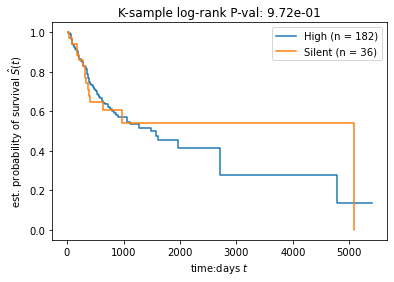

In [239]:
chisq,pval = Survival_kmCurve(df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'],'FGA_status',)
print(chisq,pval)

primary_site=Larynx        -0.470099
primary_site=Oral Cavity   -0.367958
primary_site=Oropharynx    -0.074700
dtype: float64
1.814748554645367 0.6117307563218148


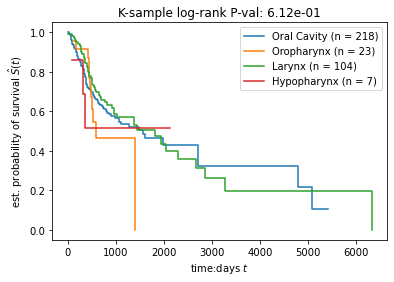

In [240]:
chisq,pval = Survival_kmCurve(df_merged_HPVneg,'primary_site')
print(chisq,pval)

hpv_status=Positive   -2.040584
dtype: float64
15.754687360300702 7.210904804581319e-05


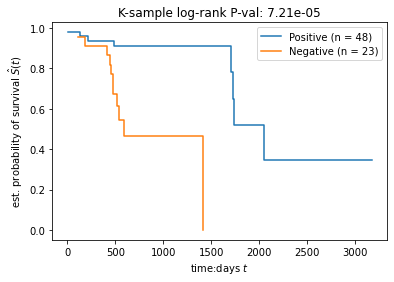

In [241]:
chisq,pval = Survival_kmCurve(df_merged_nonrelative[df_merged_nonrelative['primary_site']=='Oropharynx'],'hpv_status')
print(chisq,pval)

In [130]:
data_x = df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'].dropna()

In [131]:
data_y = df_merged_HPVneg[df_merged_HPVneg['primary_site']=='Oral Cavity'].dropna().loc[:,df_tcga_survival.columns[1:]]

In [132]:
data_y.loc[:,'Overall Survival Status'] = data_y['Overall Survival Status'].map({'DECEASED':True,'LIVING':False})

In [133]:
data_y['Overall Survival (Days)'] = data_y['Overall Survival (Months)']*30

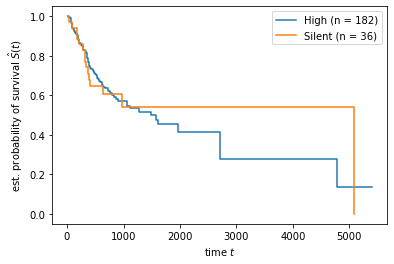

In [135]:
for value in data_x["FGA_status"].unique():
    mask = data_x["FGA_status"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Overall Survival Status"][mask],
                                                           data_y["Overall Survival (Days)"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")